In [96]:
import numpy as np
import pandas as pd
import yaml
import torch
from copy import deepcopy
import matplotlib.pyplot as plt
from celldreamer.eval.eval_utils import normalize_and_compute_metrics
import scipy.sparse as sp
from celldreamer.eval.eval_utils import join_real_generated

from torch import nn
import scanpy as sc    

from celldreamer.data.scrnaseq_loader import RNAseqLoader
from celldreamer.models.featurizers.category_featurizer import CategoricalFeaturizer
from celldreamer.models.fm.fm import FM
from celldreamer.eval.optimal_transport import wasserstein
import random
from celldreamer.models.base.encoder_model import EncoderModel
from celldreamer.models.base.utils import unsqueeze_right
from celldreamer.paths import DATA_DIR

device  = "cuda" if torch.cuda.is_available() else "cpu"

sc.set_figure_params(dpi=100, frameon=False, fontsize=12)

**Util function**

In [97]:
dataset_config = {'dataset_path': DATA_DIR / 'processed_full_genome' / 'c_elegans' / 'c_elegans_test.h5ad',
                    'layer_key': 'X_counts',
                    'covariate_keys': ['batch', 'cell_type'],
                    'subsample_frac': 1,
                    'encoder_type': 'learnt_autoencoder',
                    'one_hot_encode_features': False,
                    'split_rates': [0.90, 0.10],
                    'cov_embedding_dimensions': 128, 
                    'multimodal': False, 
                    'is_binarized': False,
                    'theta_covariate': 'cell_type', 
                    'size_factor_covariate': 'batch',
                 }

data_path = dataset_config["dataset_path"]

dataset = RNAseqLoader(data_path=data_path,
                        layer_key=dataset_config["layer_key"],
                        covariate_keys=dataset_config["covariate_keys"],
                        subsample_frac=dataset_config["subsample_frac"], 
                        encoder_type=dataset_config["encoder_type"],
                        multimodal=dataset_config["multimodal"],
                        is_binarized=dataset_config["is_binarized"]
                      )

dataloader = torch.utils.data.DataLoader(dataset,
                                            batch_size=256,
                                            shuffle=True,
                                            num_workers=4, 
                                            drop_last=True)

in_dim = dataset.X.shape[1]
size_factor_statistics = {"mean": dataset.log_size_factor_mu, 
                                  "sd": dataset.log_size_factor_sd}


/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


## Step 2: Initialize encoder

In [98]:
encoder_config = {
    "x0_from_x_kwargs": {
        "dims": [512, 256, 100],
        "batch_norm": True,
        "dropout": False,
        "dropout_p": 0.0
    },
    "learning_rate": 0.001,
    "weight_decay": 0.00001,
    "covariate_specific_theta": False, 
    "multimodal": False,
    "is_binarized": False}


state_dict_path = "/home/icb/alessandro.palma/environment/celldreamer/project_folder/experiments/off_train_autoencoder_c_elegans_whole_genome/bd5c1915-ea4d-4428-9aeb-99d3346bcc55/checkpoints/epoch_19.ckpt"

In [99]:
encoder_model = EncoderModel(in_dim=in_dim,
                              n_cat=None,
                              conditioning_covariate=dataset_config["theta_covariate"], 
                              encoder_type=dataset_config["encoder_type"],
                              **encoder_config)

encoder_model.eval()

encoder_model.load_state_dict(torch.load(state_dict_path)["state_dict"])

<All keys matched successfully>

## Initialize FM model

In [100]:
generative_model_config = {'learning_rate': 0.0001,
                            'weight_decay': 0.00001,
                            'antithetic_time_sampling': True,
                            'sigma': 0.5}

In [101]:
ckpt = torch.load("/home/icb/alessandro.palma/environment/celldreamer/project_folder/experiments/UNGUIDED_MULTILAB_C_ELEGANS/11591ee4-8f6d-475c-a2c7-7ee50c86848f/checkpoints/last.ckpt")

denoising_model = ckpt["hyper_parameters"]["denoising_model"]
denoising_model.multimodal = False

In [102]:
print(ckpt["hyper_parameters"]["feature_embeddings"]["cell_type"].embeddings.weight)
feature_embeddings = ckpt["hyper_parameters"]["feature_embeddings"]

Parameter containing:
tensor([[ 5.0711e-01,  6.1064e-01,  3.4839e-01,  ..., -8.5727e-02,
          5.8020e-01, -1.7958e-01],
        [ 2.0639e+00, -1.5293e-01, -9.8280e-02,  ...,  1.1153e+00,
         -1.0015e-04,  3.7072e-01],
        [ 8.2488e-01,  8.1218e-01,  9.0186e-01,  ...,  3.1209e-01,
          1.5194e+00, -1.1772e+00],
        ...,
        [-6.5481e-01, -2.0881e+00, -1.2115e+00,  ..., -6.5943e-01,
          1.3288e+00,  1.2685e+00],
        [-4.0283e-01,  2.2914e+00, -1.3898e-01,  ...,  3.5392e-01,
         -6.8855e-01,  1.2416e+00],
        [-1.6988e-01, -3.0723e-01,  3.0578e-01,  ...,  2.7645e-01,
          1.1971e+00,  1.5345e-01]], device='cuda:0', requires_grad=True)


Initializations

In [10]:
generative_model = FM(
            encoder_model=encoder_model,
            denoising_model=denoising_model,
            feature_embeddings=feature_embeddings,
            plotting_folder=None,
            in_dim=50,
            size_factor_statistics=size_factor_statistics,
            covariate_list=dataset_config["covariate_keys"],
            theta_covariate=dataset_config["theta_covariate"],
            size_factor_covariate=dataset_config["size_factor_covariate"],
            model_type=denoising_model.model_type, 
            encoder_type=dataset_config["encoder_type"],
            multimodal=dataset_config["multimodal"],
            is_binarized=False,
            modality_list=None,
            guidance_weights={'cell_type': 2, 'batch': 2},
            **generative_model_config  # model_kwargs should contain the rest of the arguments
            )

generative_model.load_state_dict(ckpt["state_dict"])
generative_model.to("cuda")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'encoder_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder_model'])`.
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'denoising_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['denoising_model'])`.


FM(
  (encoder_model): EncoderModel(
    (x0_from_x): MLP(
      (net): Sequential(
        (0): Sequential(
          (0): Linear(in_features=17747, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (1): Sequential(
          (0): Linear(in_features=512, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (2): Linear(in_features=256, out_features=100, bias=True)
      )
    )
    (x_from_x0): MLP(
      (net): Sequential(
        (0): Sequential(
          (0): Linear(in_features=100, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
       

**Check the data**

In [11]:
adata_original = sc.read_h5ad(data_path)
adata_original.obs["size_factor"]=adata_original.X.A.sum(1)
adata_original.X = adata_original.layers["X_counts"].A.copy()
X = torch.tensor(adata_original.layers["X_counts"].todense())

In [12]:
adata_original.X

array([[ 7.,  0.,  2., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [11.,  0.,  5., ...,  0.,  0.,  1.],
       ...,
       [18.,  0.,  2., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [20.,  0.,  1., ...,  0.,  0.,  0.]], dtype=float32)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


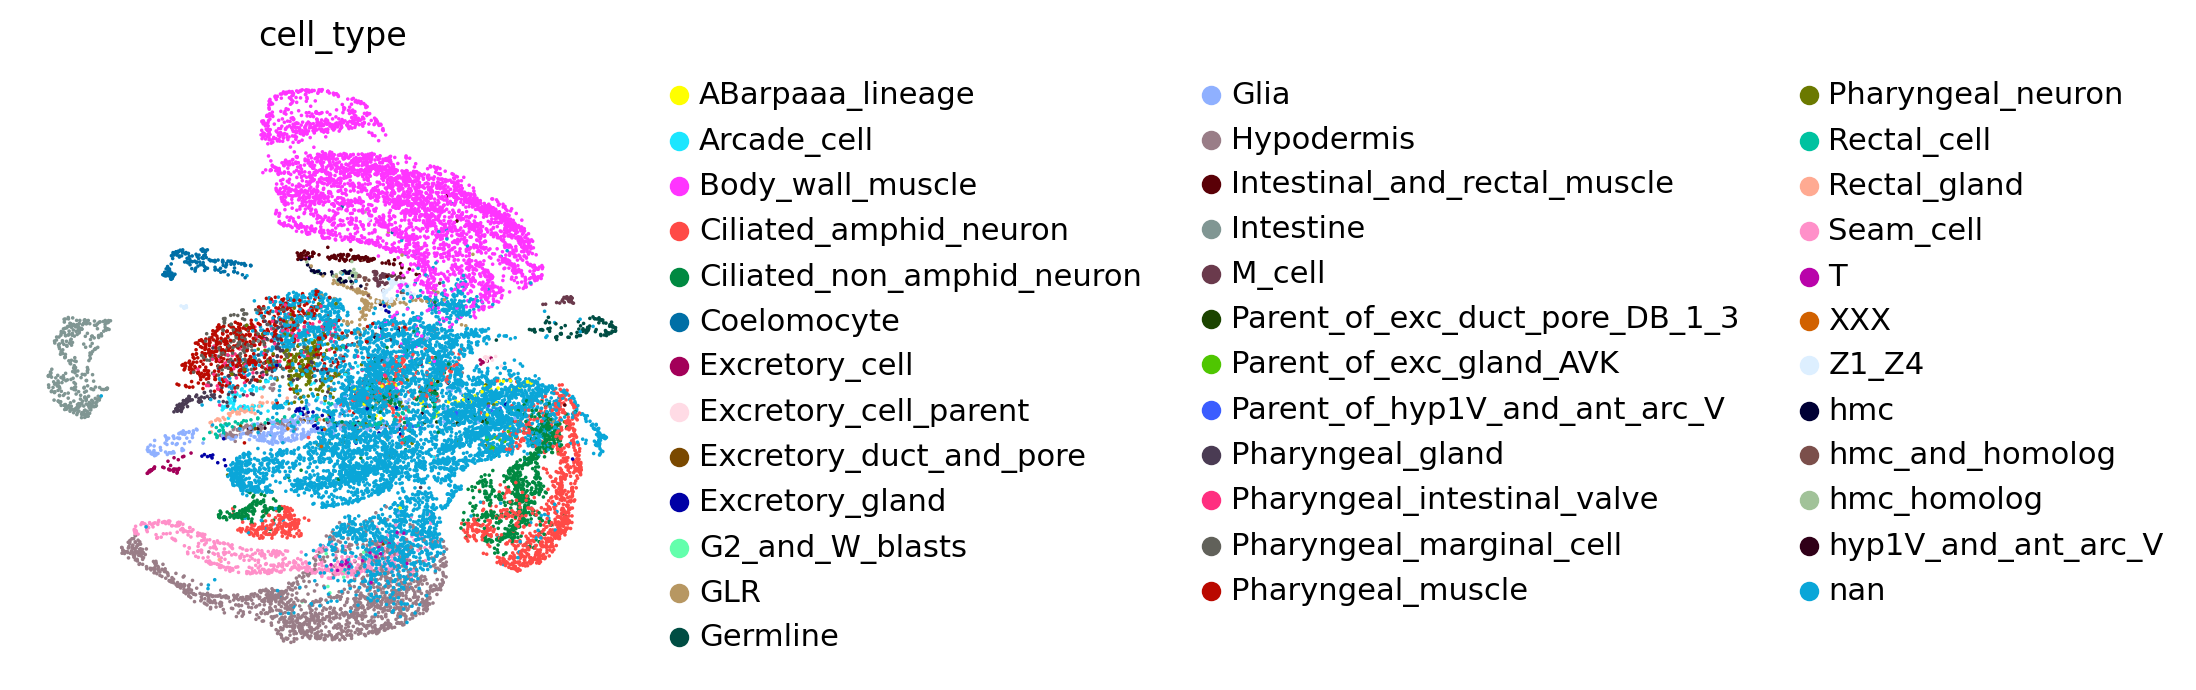

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


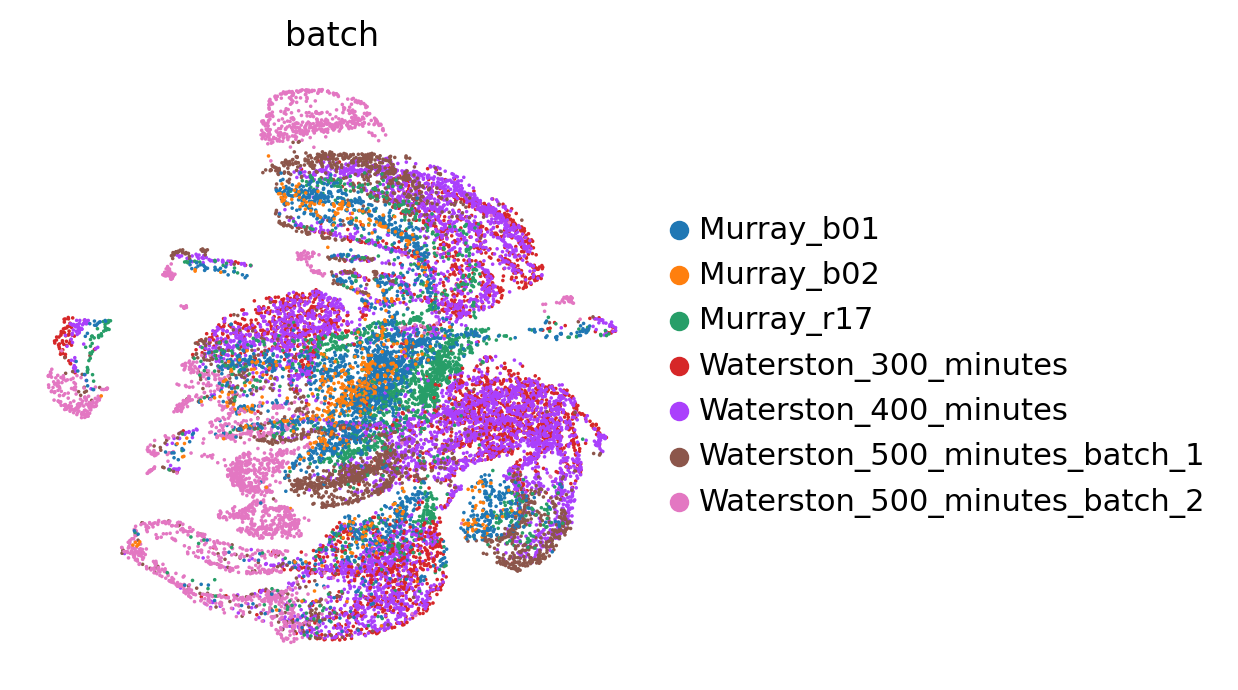

In [13]:
sc.pl.umap(adata_original, color="cell_type")
sc.pl.umap(adata_original, color="batch")

# COMBINATION OF CONDITIONS 

In [14]:
generative_model.guidance_weights

{'cell_type': 2, 'batch': 2}

In [23]:
dataset.id2cov["cell_type"]

{'ABarpaaa_lineage': 0,
 'Arcade_cell': 1,
 'Body_wall_muscle': 2,
 'Ciliated_amphid_neuron': 3,
 'Ciliated_non_amphid_neuron': 4,
 'Coelomocyte': 5,
 'Excretory_cell': 6,
 'Excretory_cell_parent': 7,
 'Excretory_duct_and_pore': 8,
 'Excretory_gland': 9,
 'G2_and_W_blasts': 10,
 'GLR': 11,
 'Germline': 12,
 'Glia': 13,
 'Hypodermis': 14,
 'Intestinal_and_rectal_muscle': 15,
 'Intestine': 16,
 'M_cell': 17,
 'Parent_of_exc_duct_pore_DB_1_3': 18,
 'Parent_of_exc_gland_AVK': 19,
 'Parent_of_hyp1V_and_ant_arc_V': 20,
 'Pharyngeal_gland': 21,
 'Pharyngeal_intestinal_valve': 22,
 'Pharyngeal_marginal_cell': 23,
 'Pharyngeal_muscle': 24,
 'Pharyngeal_neuron': 25,
 'Rectal_cell': 26,
 'Rectal_gland': 27,
 'Seam_cell': 28,
 'T': 29,
 'XXX': 30,
 'Z1_Z4': 31,
 'hmc': 32,
 'hmc_and_homolog': 33,
 'hmc_homolog': 34,
 'hyp1V_and_ant_arc_V': 35,
 'nan': 36}

In [24]:
dataset.id2cov["batch"]

{'Murray_b01': 0,
 'Murray_b02': 1,
 'Murray_r17': 2,
 'Waterston_300_minutes': 3,
 'Waterston_400_minutes': 4,
 'Waterston_500_minutes_batch_1': 5,
 'Waterston_500_minutes_batch_2': 6}

In [25]:
pd.crosstab(adata_original.obs.cell_type, adata_original.obs.batch)

batch,Murray_b01,Murray_b02,Murray_r17,Waterston_300_minutes,Waterston_400_minutes,Waterston_500_minutes_batch_1,Waterston_500_minutes_batch_2
cell_type,,,,,,,
ABarpaaa_lineage,5,2,9,18,17,1,0
Arcade_cell,30,11,5,0,5,18,21
Body_wall_muscle,404,108,240,638,1196,537,440
Ciliated_amphid_neuron,164,43,105,150,382,194,196
Ciliated_non_amphid_neuron,126,25,87,130,271,156,121
Coelomocyte,27,4,18,5,37,31,39
Excretory_cell,3,2,4,4,8,5,16
Excretory_cell_parent,1,0,2,2,8,0,0
Excretory_duct_and_pore,0,0,1,0,11,3,0


In [76]:
# Pick condition 
covariates_cell_type = 'Germline'
covariates_batch = 'Murray_r17'

condition_id_clus = dataset.id2cov["cell_type"][covariates_cell_type]
condition_id_batch = dataset.id2cov["batch"][covariates_batch]

adata_cond = adata_original[np.logical_and(adata_original.obs.cell_type==covariates_cell_type, 
                                           adata_original.obs.batch==covariates_batch)]
n_to_generate = 20

classes = {"cell_type": condition_id_clus*torch.ones(n_to_generate).long(), 
           "batch": condition_id_batch*torch.ones(n_to_generate).long()}

classes_str = {"cell_type": [covariates_cell_type for n in range(n_to_generate)], 
           "batch": [covariates_batch for n in range(n_to_generate)]}

log_size_factors = torch.log(torch.tensor(adata_cond.layers["X_counts"].sum(1))).cuda()

In [77]:
X_generated = generative_model.sample(batch_size=n_to_generate,
                                        n_sample_steps=100, 
                                        theta_covariate="cell_type", 
                                        size_factor_covariate="batch",
                                        conditioning_covariates=["cell_type", "batch"],
                                        covariate_indices=classes, 
                                        log_size_factor=None)

X_generated = X_generated.to("cpu")

adata_generated = sc.AnnData(X=X_generated.numpy())

In [78]:
adata_merged = join_real_generated(adata_original, adata_generated, True, classes_str, ["cell_type", "batch"])

In [79]:
X_generated.sum(1).max()

tensor(10446.)

In [80]:
X.sum(1).max()

tensor(126183.)

In [81]:
sc.pp.neighbors(adata_merged)
sc.tl.umap(adata_merged)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_utils.py:431: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/pytho

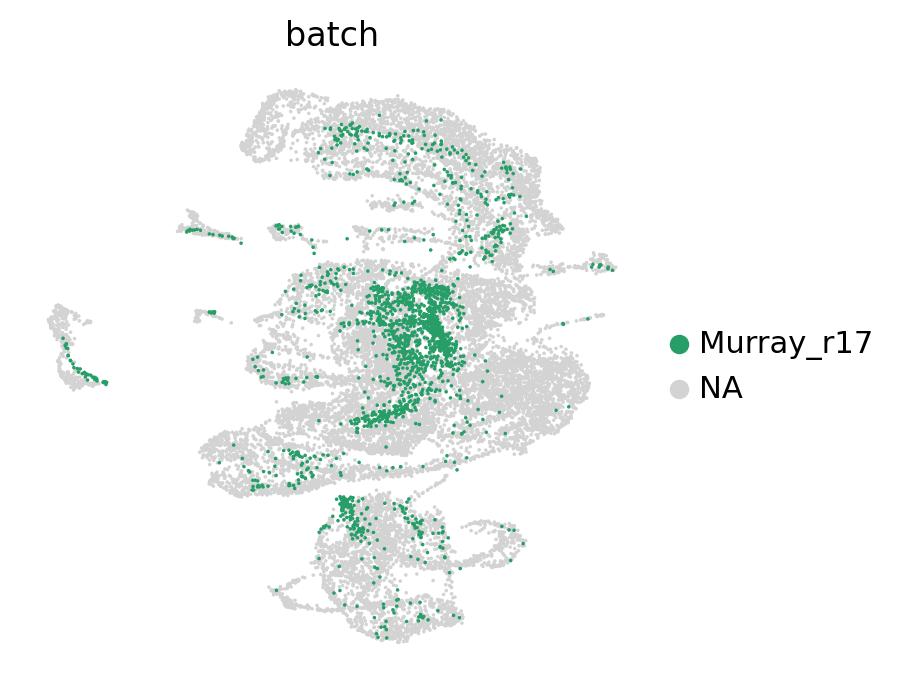

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_utils.py:431: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/pytho

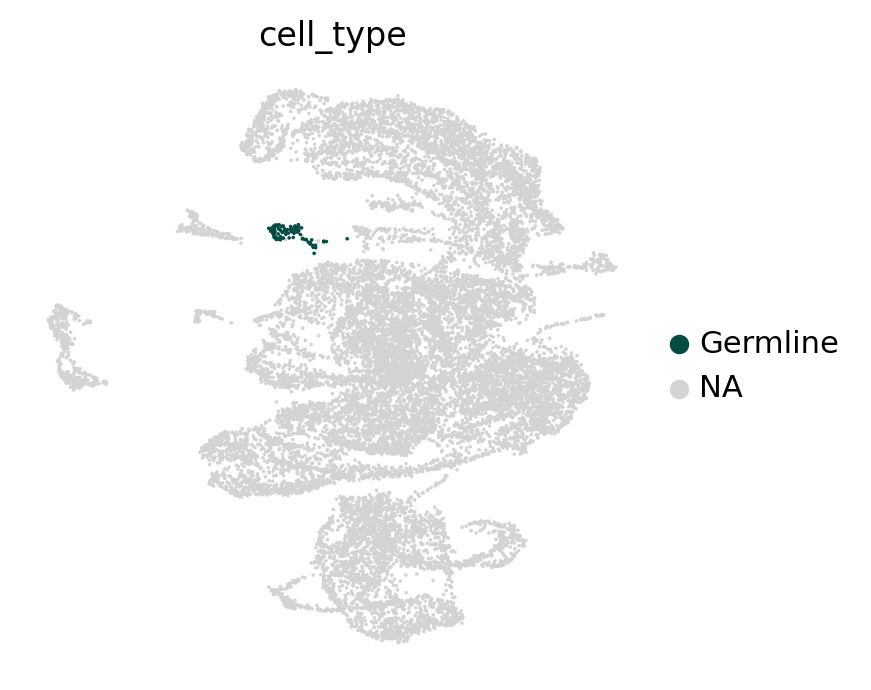

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


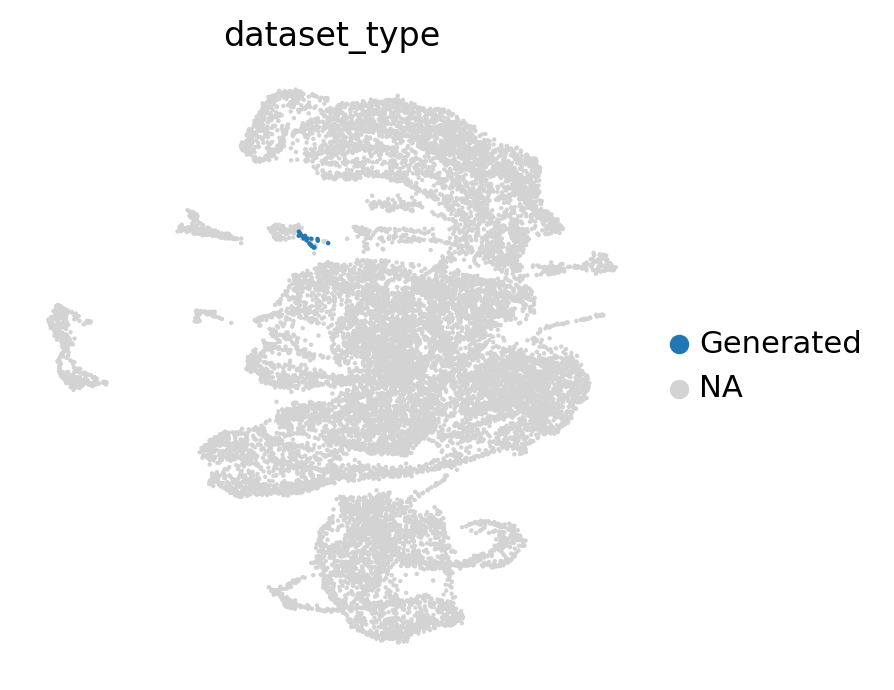

In [95]:
sc.pl.umap(adata_merged[adata_merged.obs.dataset_type=="Real"], color="batch", groups="Murray_r17")
sc.pl.umap(adata_merged[adata_merged.obs.dataset_type=="Real"], color="cell_type", groups="Germline")
sc.pl.umap(adata_merged, color="dataset_type", groups="Generated", s=10)

In [103]:
# adata_comb_plot = adata_merged[np.logical_and(adata_merged.obs.cell_type=="Germline", adata_merged.obs.batch=="Murray_r17")]
# sc.pl.umap(adata_comb_plot, color="cell_type")

In [104]:
# np.logical_and(adata_merged[adata_merged.obs.cell_type=="Germline"], adata_merged[adata_merged.obs.batch=="Murray_r17"])